## B cells versus T cells
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_FragPipe(month="lymph_forPRIDE")

data_raw

,Subject1_FACS145_B_C10,Subject1_FACS145_B_C11,Subject1_FACS145_B_C12,Subject1_FACS145_B_C13,Subject1_FACS145_B_C9,Subject1_FACS145_T_D10,Subject1_FACS145_T_D11,Subject1_FACS145_T_D12,Subject1_FACS145_T_D13,Subject1_FACS145_T_D9
Protein ID,,,,,,,,,,
A0A0B4J2D5,887620.10,1370180.1,2062984.60,2450476.00,1365915.2,328929.3,361140.16,186872.61,0.00,202940.38
A0AVT1,436741.90,703239.6,862428.60,418775.84,1720851.8,0.0,586732.06,0.00,0.00,317229.88
A0FGR8,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
A6NHR9,164891.88,0.0,0.00,0.00,0.0,0.0,0.00,0.00,436801.84,0.00
A8MWD9,520638.70,1043206.2,703606.44,1145135.20,465469.2,0.0,465638.90,0.00,0.00,339949.03
...,...,...,...,...,...,...,...,...,...,...
Q9Y295,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
Q9Y3F4,0.00,497213.7,0.00,0.00,0.0,0.0,476313.30,0.00,0.00,0.00
Q13418,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00


These are some methods that assist with the data analysis, such as checking if a value was measured or not and if the protein was measured in each type.

In [2]:
import data_utils

Before any analysis, we log normalize and median normalize across runs.

In [3]:
data_log2_normalized = data_utils.normalize(data_raw)

Our next steps will require separating the runs by cell type, to compare B cells to T cells. As you see above, the pattern for naming the columns is "Intensity ", B or T indicating cell type, and the replicate number. Here we define the list of cell types that the functions should look for based on the naming pattern.

In [4]:
cell_types=['B_', 'T_']

Here we record which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. Note that <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type; do not set it to a number greater than the replicates run or no proteins will be returned.

In [5]:
present_5of5_only_in = data_log2_normalized.apply(data_utils.check_presence_absence, axis=1, 
                                             min_reps=5, cell_types=cell_types).dropna()
print("Proteins identified in 5/5 replicates only in:")
print(present_5of5_only_in.value_counts())
data_in_5of5_one_type =data_log2_normalized.loc[present_5of5_only_in.index]
data_in_5of5_one_type['Type'] = present_5of5_only_in

Proteins identified in 5/5 replicates only in:
B_    28
T_    22
dtype: int64


For our analysis, present in more than half, or at least 3 out of 5 replicates, is considered clear although it is interesting to note those proteins identified in all replicates of one type.

In [6]:
present_only_in = data_log2_normalized.apply(data_utils.check_presence_absence, axis=1, 
                                             min_reps=3, cell_types=cell_types).dropna()
print("Proteins identified only in:")
print(present_only_in.value_counts())
data_in_one_type =data_log2_normalized.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

Proteins identified only in:
B_    71
T_    55
dtype: int64


Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [7]:
indecies = data_log2_normalized.apply(data_utils.check_three_of_each_type, axis=1, cell_types=cell_types)
data = data_log2_normalized[indecies]

In [8]:
print ("Total groups identified:")
print(data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (data.shape[0])

Total groups identified:
1637
Proteins identified in at least 3 of each cell type:	
961


Now we calulate p values using a ttest. 

In [9]:
#Call ttest function
tstats = data.apply(data_utils.ttest_wrapper, axis=1, cell_types=cell_types)

D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Here we calculate fold change.

In [10]:
tstats['log2(B)-log2(T)'] = data.apply(data_utils.get_fold_changes, axis=1, cell_types=cell_types)

Fold change and p values allow us to create a volcano plot.

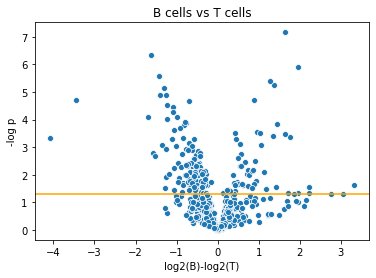

In [11]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure.set_title("B cells vs T cells")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

Next we will identify the altered proteins.

In [12]:
altered = tstats.apply(data_utils.is_altered, axis=1, change_factor=False).dropna()

These are significantly altered (p<0.01) without restricting by the magnitude of change:

In [13]:
altered.value_counts()

T cells    69
B cells    26
dtype: int64

In [14]:
print("Here are counts for other p and change cutoffs:")
print("P<0.05, >150% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=2).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=5).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=2).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=5).value_counts()) #5 times larger

Here are counts for other p and change cutoffs:
P<0.05, >150% of the other type
T cells    63
B cells    33
dtype: int64

P<0.05, >200% of the other type
T cells    24
B cells    19
dtype: int64

P<0.05, >500% of the other type
T cells    2
B cells    2
dtype: int64

P<0.01, >150% of the other type
T cells    45
B cells    19
dtype: int64

P<0.01, >200% of the other type
T cells    21
B cells    11
dtype: int64

P<0.01, >500% of the other type
T cells    2
dtype: int64


### Differentially expressed proteins

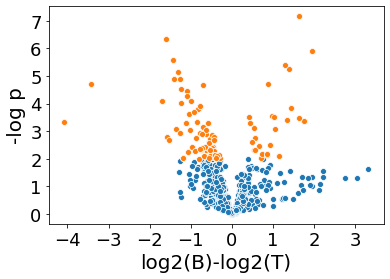

In [30]:
figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure2 = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats.loc[altered.index])
plt.rc('axes',labelsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.title("B cells vs T cells", fontsize=20)

plt.savefig("data/AutoPOTS_forPRIDE/BvsT.png", bbox_inches='tight', dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.

In [16]:
protein_names = load_data.load_fasta()

In [17]:
import pandas as pd
protein_names_by_group={}
for ID in data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in B cells from those heightened in T cells.

In [18]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values('log2(B)-log2(T)',
                        ascending=False)[['Name','GeneID','log2(B)-log2(T)','pvalue']]
higher_in_B_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] >0]
higher_in_T_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [19]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

B_cell_only_geneset = data_in_one_type[(data_in_one_type.Type==' B_')]
T_cell_only_geneset= data_in_one_type[(data_in_one_type.Type==' T_')]

The following are the names to get the set of proteins as mentioned. For clarity, they are simply listed rather than run as code here.

### Proteins Higher in B Cells:

### Proteins Only in B Cells:

### Proteins higher or only in B cells by GeneID
<code>B_cell_set</code> is defined here as both the above lists of names, those higher or only in B cells.

In [20]:
B_cell_set = list(higher_in_B_cells.GeneID)+list(B_cell_only_geneset.GeneID)

### Proteins Higher in T Cells:

### Proteins Only in T Cells:

### Proteins higher or only in T cells by GeneID
<code>T_cell_set</code> is defined here as both the above lists of names, those higher or only in T cells.

In [21]:
T_cell_set = list(higher_in_T_cells.GeneID)+list(T_cell_only_geneset.GeneID)

## Suplementary Table: Distinguished Proteins
Here we combine the data from the four categories in one dataframe and output it to a tab-separated file.

First, we get the names ofthe distinguished proteins.

In [22]:
distinguished_proteins = pd.concat([data_in_one_type[["GeneID"]],
                                   altered_proteins[["GeneID", "log2(B)-log2(T)", "pvalue"]]])

Next, we get the intensity data for these proteins.

In [23]:
altered_data = data.loc[altered.index]
one_type_data = data_in_one_type.drop(columns=["Type","Name","GeneID"], inplace=False)
altered_data = pd.concat([altered_data,one_type_data])

Next, we average by cell type, creating new columns in our <code>distinguished_proteins</code> dataframe.

In [24]:
import numpy as np
samples=np.array(data_raw.columns.values)

from statistics import mean

def mean_noNan(ser):
    ser = ser.dropna()
    if len(ser)==0:
        return np.nan
    return mean(ser)

for cell_type in cell_types:
    cells_of_type = list(s for i,s in enumerate(samples) if cell_type in s)
    type_data = altered_data[cells_of_type]
    means = type_data.apply(mean_noNan, axis=1)
    
    distinguished_proteins[("Mean {0}cells".format(cell_type))] = means

Here we check the column order and rearrange it as we like.

In [25]:
distinguished_proteins.columns

Index(['GeneID', 'log2(B)-log2(T)', 'pvalue', 'Mean B_cells', 'Mean T_cells'], dtype='object')

In [26]:
distinguished_proteins = distinguished_proteins[["GeneID", "Mean B_cells", "Mean T_cells", "log2(B)-log2(T)", "pvalue"]]

Here we sort the proteins. This will sort them such that high abundance in B come first, down it low abundance in B, and finally sorting the T only proteins from low to high.

In [27]:
distinguished_proteins.sort_values(["Mean B_cells", "Mean T_cells"], ascending=[False, False], inplace=True)

Finally, we have the finished dataframe.

In [28]:
distinguished_proteins

,GeneID,Mean B_cells,Mean T_cells,log2(B)-log2(T),pvalue
Protein ID,,,,,
P68032,ACTC,8.237346,8.520918,-0.283572,0.009440
P68133,ACTS,8.227920,8.530345,-0.302425,0.007259
Q06830,PRDX1,6.089962,5.587467,0.502495,0.002417
Q6DN03,H2B2C,4.889238,5.874517,-0.985278,0.000082
P59665,DEF1,4.854990,3.885252,0.969738,0.000293
...,...,...,...,...,...
Q9UHL4,DPP2,NaN,-2.454157,NaN,NaN
Q8IV04,TB10C,NaN,-2.623243,NaN,NaN
P05023,AT1A1,NaN,-2.673664,NaN,NaN


The last step is saving this dataframe to a file.

In [29]:
distinguished_proteins.to_csv('data/AutoPOTS_forPRIDE/distinguished_proteins_FP_nMBR.tsv', sep='\t')